# Artificial Intelligence for Big Data Systems
## Assignment 3: Sentiment Analysis for Tweeter Data
### Stefan Velev, 0MI3400521, Big Data Technologies


#### **1. Import required Python packages**

In [65]:
# Standard Library
import re
import string

# Third-Party Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
import sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
import scipy
from scipy.special import softmax
from tqdm import tqdm
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

#### **2. Twitter dataset analysis**

#### 2.1 Reading the dataset

***Sentiment140 Dataset - 1.6 million tweets***

*http://www.kaggle.com/datasets/kazanova/sentiment140/data*

*Go, A., Bhayani, R. and Huang, L., 2009.*

*Twitter sentiment classification using distant supervision.*

*CS224N Project Report, Stanford, 1(2009), p.12.*

***Description of the fields:***

***target*** - *the polarity of the tweet (0 = negative, 4 = positive)*

***ids*** - *the id of the tweet*

***date*** - *the date of the tweet*

***flag*** - *the query*

***user*** - *the user that tweeted*

***text*** - *the text of the tweet*

In [66]:
DATASET_FILE_NAME = "./data/Tweets.csv"
DATASET_COLUMNS = ['target', 'ids', 'date', 'flag', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv(DATASET_FILE_NAME, encoding = DATASET_ENCODING, names = DATASET_COLUMNS)
df.head()

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

#### 2.2 Extracting column names of the data frame

In [67]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

#### 2.3 Printing the length of the dataframe

In [68]:
print('The length of the dataset is:', len(df))

The length of the dataset is: 1600000


#### 2.4 Printing the shape of the data frame - dimensionality

In [69]:
print(df.shape)

(1600000, 6)


#### 2.5 Printing a concise summary of the data frame - structure, data types,non-nullcounts, etc.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#### 2.6 Printing the data types of all columns of the data frame

In [71]:
print(df.dtypes)

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object


#### 2.7 Printing the number of rows with null values in the data frame

In [72]:
print(np.sum(df.isnull().any(axis=1)))

0


#### 2.8 Printing the unique values of the target column and their count in the data frame

In [73]:
print(df['target'].unique())

[0 4]


#### 2.9 Printing the count of the target values in the data frame

In [74]:
print(df['target'].nunique())

2


#### 2.10 Visualising the distribution of the target values in the data frame

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

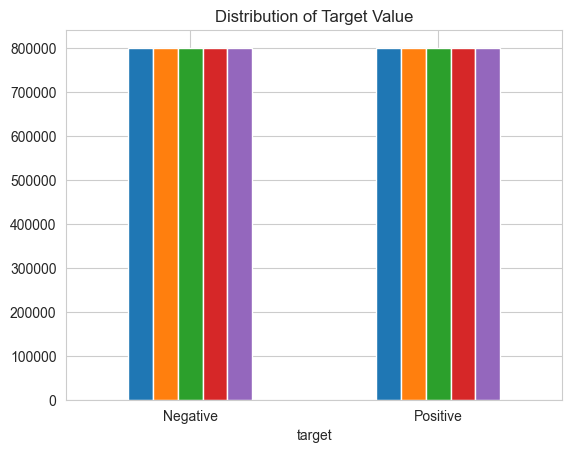

In [75]:
ax = df.groupby('target').count().plot(kind = 'bar', title = 'Distribution of Target Value', legend = False)
ax.set_xticklabels(['Negative', 'Positive'], rotation = 0)

<Axes: xlabel='target', ylabel='count'>

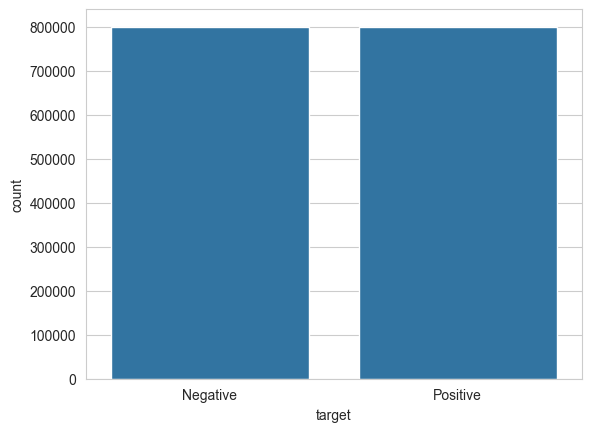

In [76]:
names_mapping = {0: 'Negative', 4: 'Positive'}
sns.countplot(x = df['target'].map(names_mapping), data = df)

#### **3. Data Preprocessing**

#### 3.1 Attribute selection

In [77]:
data_df = df[['text', 'target']]

#### 3.2 Label Encoding

In [78]:
data_df.loc[data_df['target'] == 4, 'target'] = 1

In [79]:
print(data_df['target'].unique())

[0 1]


#### 3.3 Data Segregation

In [80]:
data_negative_df = data_df[data_df['target'] == 0]
data_positive_df = data_df[data_df['target'] == 1]

#### 3.4 Data Subsampling

In [81]:
data_positive_df = data_positive_df.sample(n = 400000, random_state = 42)
data_negative_df = data_negative_df.sample(n = 400000, random_state = 42)

#### 3.5 Data Merging

In [82]:
merged_df = pd.concat([data_positive_df, data_negative_df])
merged_df_2 = pd.concat([data_positive_df, data_negative_df])

In [83]:
merged_df.head()

text  target
1012188  Is lookin 4ward to a long weekend  really dont...       1
1099036  #myweakness  Is music and i live to meet the p...       1
1275978           figured out the Internet on my new iPod        1
1388988  @hillsongunited can't wait to worship with you...       1
938859   @sillybeggar Congrats James !! I'm sure the bo...       1

In [84]:
merged_df.reset_index(drop=True, inplace=True)
merged_df_2.reset_index(drop=True, inplace=True)

In [85]:
merged_df.head()

text  target
0  Is lookin 4ward to a long weekend  really dont...       1
1  #myweakness  Is music and i live to meet the p...       1
2           figured out the Internet on my new iPod        1
3  @hillsongunited can't wait to worship with you...       1
4  @sillybeggar Congrats James !! I'm sure the bo...       1

#### 3.6 Data Transformation

##### 3.6.1 Lowercasing

In [86]:
merged_df.head()

text  target
0  Is lookin 4ward to a long weekend  really dont...       1
1  #myweakness  Is music and i live to meet the p...       1
2           figured out the Internet on my new iPod        1
3  @hillsongunited can't wait to worship with you...       1
4  @sillybeggar Congrats James !! I'm sure the bo...       1

In [87]:
merged_df['text'] = merged_df['text'].str.lower()

In [88]:
merged_df.head()

text  target
0  is lookin 4ward to a long weekend  really dont...       1
1  #myweakness  is music and i live to meet the p...       1
2           figured out the internet on my new ipod        1
3  @hillsongunited can't wait to worship with you...       1
4  @sillybeggar congrats james !! i'm sure the bo...       1

##### 3.6.2 Removing stopwords

In [89]:
nltk.download('stopwords')
stopwords = stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stvel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
merged_df.head()

text  target
0  is lookin 4ward to a long weekend  really dont...       1
1  #myweakness  is music and i live to meet the p...       1
2           figured out the internet on my new ipod        1
3  @hillsongunited can't wait to worship with you...       1
4  @sillybeggar congrats james !! i'm sure the bo...       1

In [91]:
stopwords_set = set(stopwords)
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_set])
merged_df['text'] = merged_df['text'].apply(lambda text: remove_stopwords(text))

In [92]:
merged_df.head()

text  target
0  lookin 4ward long weekend really dont want go ...       1
1            #myweakness music live meet people make       1
2                          figured internet new ipod       1
3  @hillsongunited can't wait worship guys tonigh...       1
4  @sillybeggar congrats james !! i'm sure book g...       1

##### 3.6.3 Removing URLs

In [93]:
print(merged_df['text'].iloc[27034])

parents, here's website full free preschool computer games, enjoy http://bit.ly/pcql5 ms. destiny


In [94]:
def remove_URLs(text):
    return re.sub(r'(www\.[^\s]+|https?://[^\s]+)', '', text).strip()
merged_df['text'] = merged_df['text'].apply(remove_URLs)

In [95]:
print(merged_df['text'].iloc[27034])

parents, here's website full free preschool computer games, enjoy  ms. destiny


##### 3.6.4 Removing punctuation

In [96]:
punctuation_list = string.punctuation
print(punctuation_list)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [97]:
merged_df.head()

text  target
0  lookin 4ward long weekend really dont want go ...       1
1            #myweakness music live meet people make       1
2                          figured internet new ipod       1
3  @hillsongunited can't wait worship guys tonigh...       1
4  @sillybeggar congrats james !! i'm sure book g...       1

In [98]:
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuation_list)
    return text.translate(translator)
merged_df['text'] = merged_df['text'].apply(remove_punctuations)

In [99]:
merged_df.head()

text  target
0  lookin 4ward long weekend really dont want go ...       1
1             myweakness music live meet people make       1
2                          figured internet new ipod       1
3  hillsongunited cant wait worship guys tonight ...       1
4  sillybeggar congrats james  im sure book going...       1

##### 3.6.5 Removing repeated characters

In [100]:
merged_df.head(10)

text  target
0  lookin 4ward long weekend really dont want go ...       1
1             myweakness music live meet people make       1
2                          figured internet new ipod       1
3  hillsongunited cant wait worship guys tonight ...       1
4  sillybeggar congrats james  im sure book going...       1
5   debbybruck beautiful children smile world smiles       1
6                   bethofalltrades   happy birthday       1
7  adinfinitum yes can ultimate vegan guide eric ...       1
8                     getting writing mee fun nightt       1
9  noopman remote prefer site theres substitute w...       1

In [101]:
def remove_repeated_characters(text):
    return re.sub(r'(.)\1+', r'\1', text)
merged_df['text'] = merged_df['text'].apply(remove_repeated_characters)

In [102]:
merged_df.head(10)

text  target
0  lokin 4ward long wekend realy dont want go wor...       1
1               myweaknes music live met people make       1
2                          figured internet new ipod       1
3  hilsongunited cant wait worship guys tonight i...       1
4  silybegar congrats james im sure bok going hug...       1
5    debybruck beautiful children smile world smiles       1
6                       bethofaltrades hapy birthday       1
7  adinfinitum yes can ultimate vegan guide eric ...       1
8                        geting writing me fun night       1
9  nopman remote prefer site theres substitute wo...       1

##### 3.6.6 Removing numbers

In [103]:
merged_df.head()

text  target
0  lokin 4ward long wekend realy dont want go wor...       1
1               myweaknes music live met people make       1
2                          figured internet new ipod       1
3  hilsongunited cant wait worship guys tonight i...       1
4  silybegar congrats james im sure bok going hug...       1

In [104]:
def remove_numbers(text):
    return re.sub('[0-9]+', '', text)
merged_df['text'] = merged_df['text'].apply(remove_numbers)

In [105]:
merged_df.head()

text  target
0  lokin ward long wekend realy dont want go work...       1
1               myweaknes music live met people make       1
2                          figured internet new ipod       1
3  hilsongunited cant wait worship guys tonight i...       1
4  silybegar congrats james im sure bok going hug...       1

##### 3.6.7 Tokenization

In [106]:
merged_df.head()

text  target
0  lokin ward long wekend realy dont want go work...       1
1               myweaknes music live met people make       1
2                          figured internet new ipod       1
3  hilsongunited cant wait worship guys tonight i...       1
4  silybegar congrats james im sure bok going hug...       1

In [107]:
tokenizer = RegexpTokenizer(r'\w+')
merged_df['text'] = merged_df['text'].apply(tokenizer.tokenize)

In [108]:
merged_df.head()

text  target
0  [lokin, ward, long, wekend, realy, dont, want,...       1
1        [myweaknes, music, live, met, people, make]       1
2                     [figured, internet, new, ipod]       1
3  [hilsongunited, cant, wait, worship, guys, ton...       1
4  [silybegar, congrats, james, im, sure, bok, go...       1

##### 3.6.8 Stemming

In [109]:
merged_df.head()

text  target
0  [lokin, ward, long, wekend, realy, dont, want,...       1
1        [myweaknes, music, live, met, people, make]       1
2                     [figured, internet, new, ipod]       1
3  [hilsongunited, cant, wait, worship, guys, ton...       1
4  [silybegar, congrats, james, im, sure, bok, go...       1

In [110]:
st = nltk.PorterStemmer()
def stemming(text):
    return [st.stem(word) for word in text]
merged_df['text'] = merged_df['text'].apply(stemming)

In [111]:
merged_df.head()

text  target
0  [lokin, ward, long, wekend, reali, dont, want,...       1
1           [myweakn, music, live, met, peopl, make]       1
2                       [figur, internet, new, ipod]       1
3  [hilsongunit, cant, wait, worship, guy, tonigh...       1
4  [silybegar, congrat, jame, im, sure, bok, go, ...       1

##### 3.6.9 Lemmatization

In [112]:
merged_df.head(10)

text  target
0  [lokin, ward, long, wekend, reali, dont, want,...       1
1           [myweakn, music, live, met, peopl, make]       1
2                       [figur, internet, new, ipod]       1
3  [hilsongunit, cant, wait, worship, guy, tonigh...       1
4  [silybegar, congrat, jame, im, sure, bok, go, ...       1
5  [debybruck, beauti, children, smile, world, sm...       1
6                     [bethofaltrad, hapi, birthday]       1
7  [adinfinitum, ye, can, ultim, vegan, guid, eri...       1
8                      [gete, write, me, fun, night]       1
9  [nopman, remot, prefer, site, there, substitut...       1

In [113]:
wnlm = WordNetLemmatizer()
def lemmatization(text):
    return [wnlm.lemmatize(word) for word in text]
merged_df['text'] = merged_df['text'].apply(lemmatization)

In [114]:
merged_df.head(10)

text  target
0  [lokin, ward, long, wekend, reali, dont, want,...       1
1           [myweakn, music, live, met, peopl, make]       1
2                       [figur, internet, new, ipod]       1
3  [hilsongunit, cant, wait, worship, guy, tonigh...       1
4  [silybegar, congrat, jame, im, sure, bok, go, ...       1
5    [debybruck, beauti, child, smile, world, smile]       1
6                     [bethofaltrad, hapi, birthday]       1
7  [adinfinitum, ye, can, ultim, vegan, guid, eri...       1
8                      [gete, write, me, fun, night]       1
9  [nopman, remot, prefer, site, there, substitut...       1

#### 3.7 Visualising a word cloud

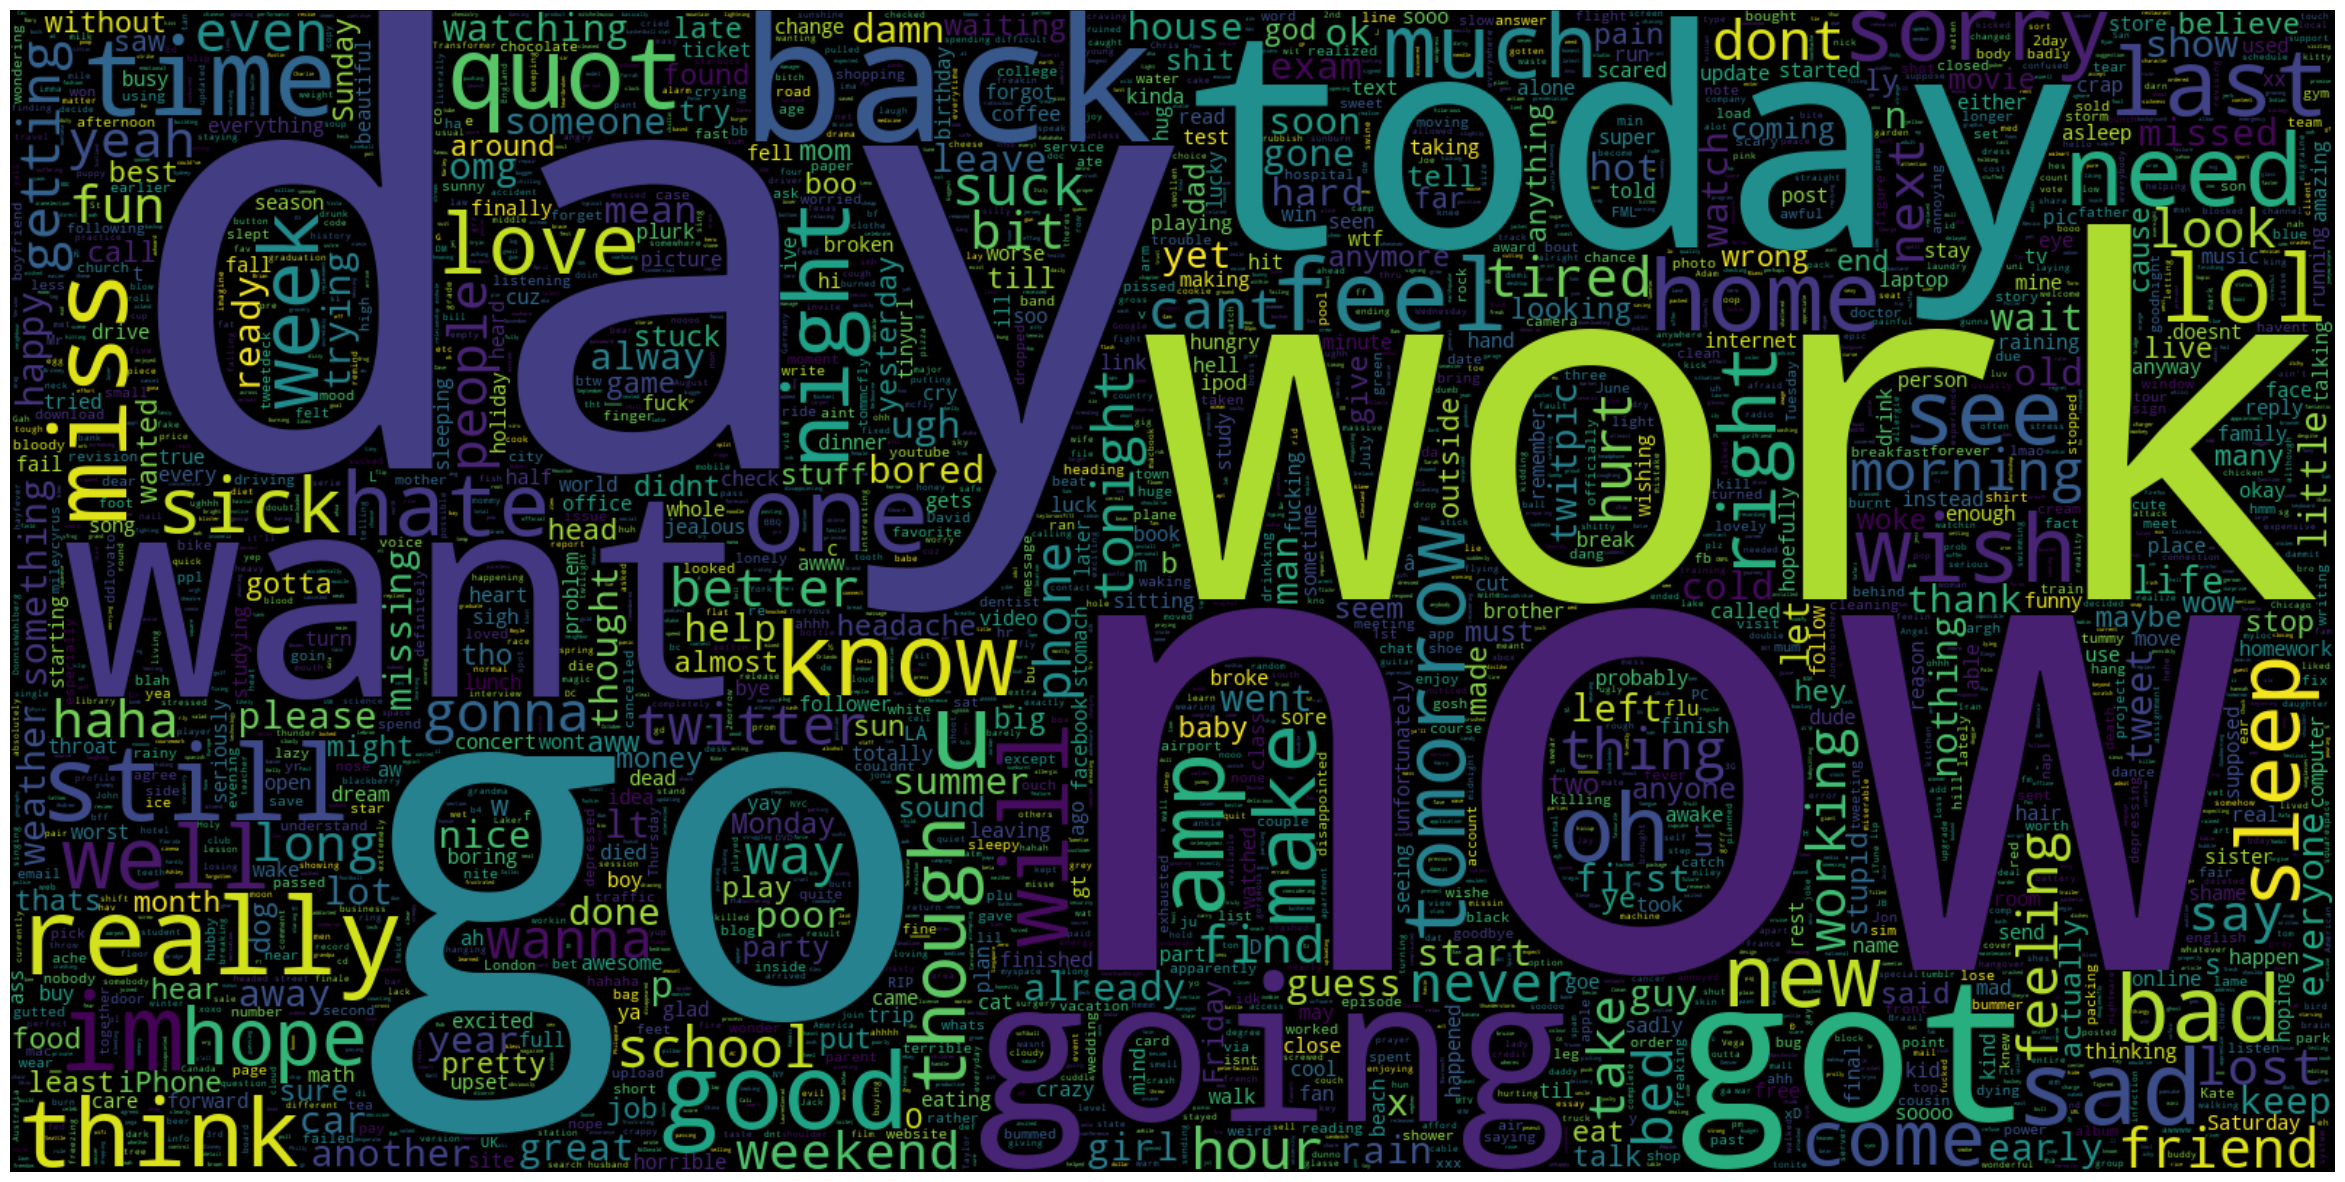

In [115]:
data_negative_df = data_df['text'][:800000]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 3000, width = 1600, height = 800, collocations = False).generate(" ".join(data_negative_df))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

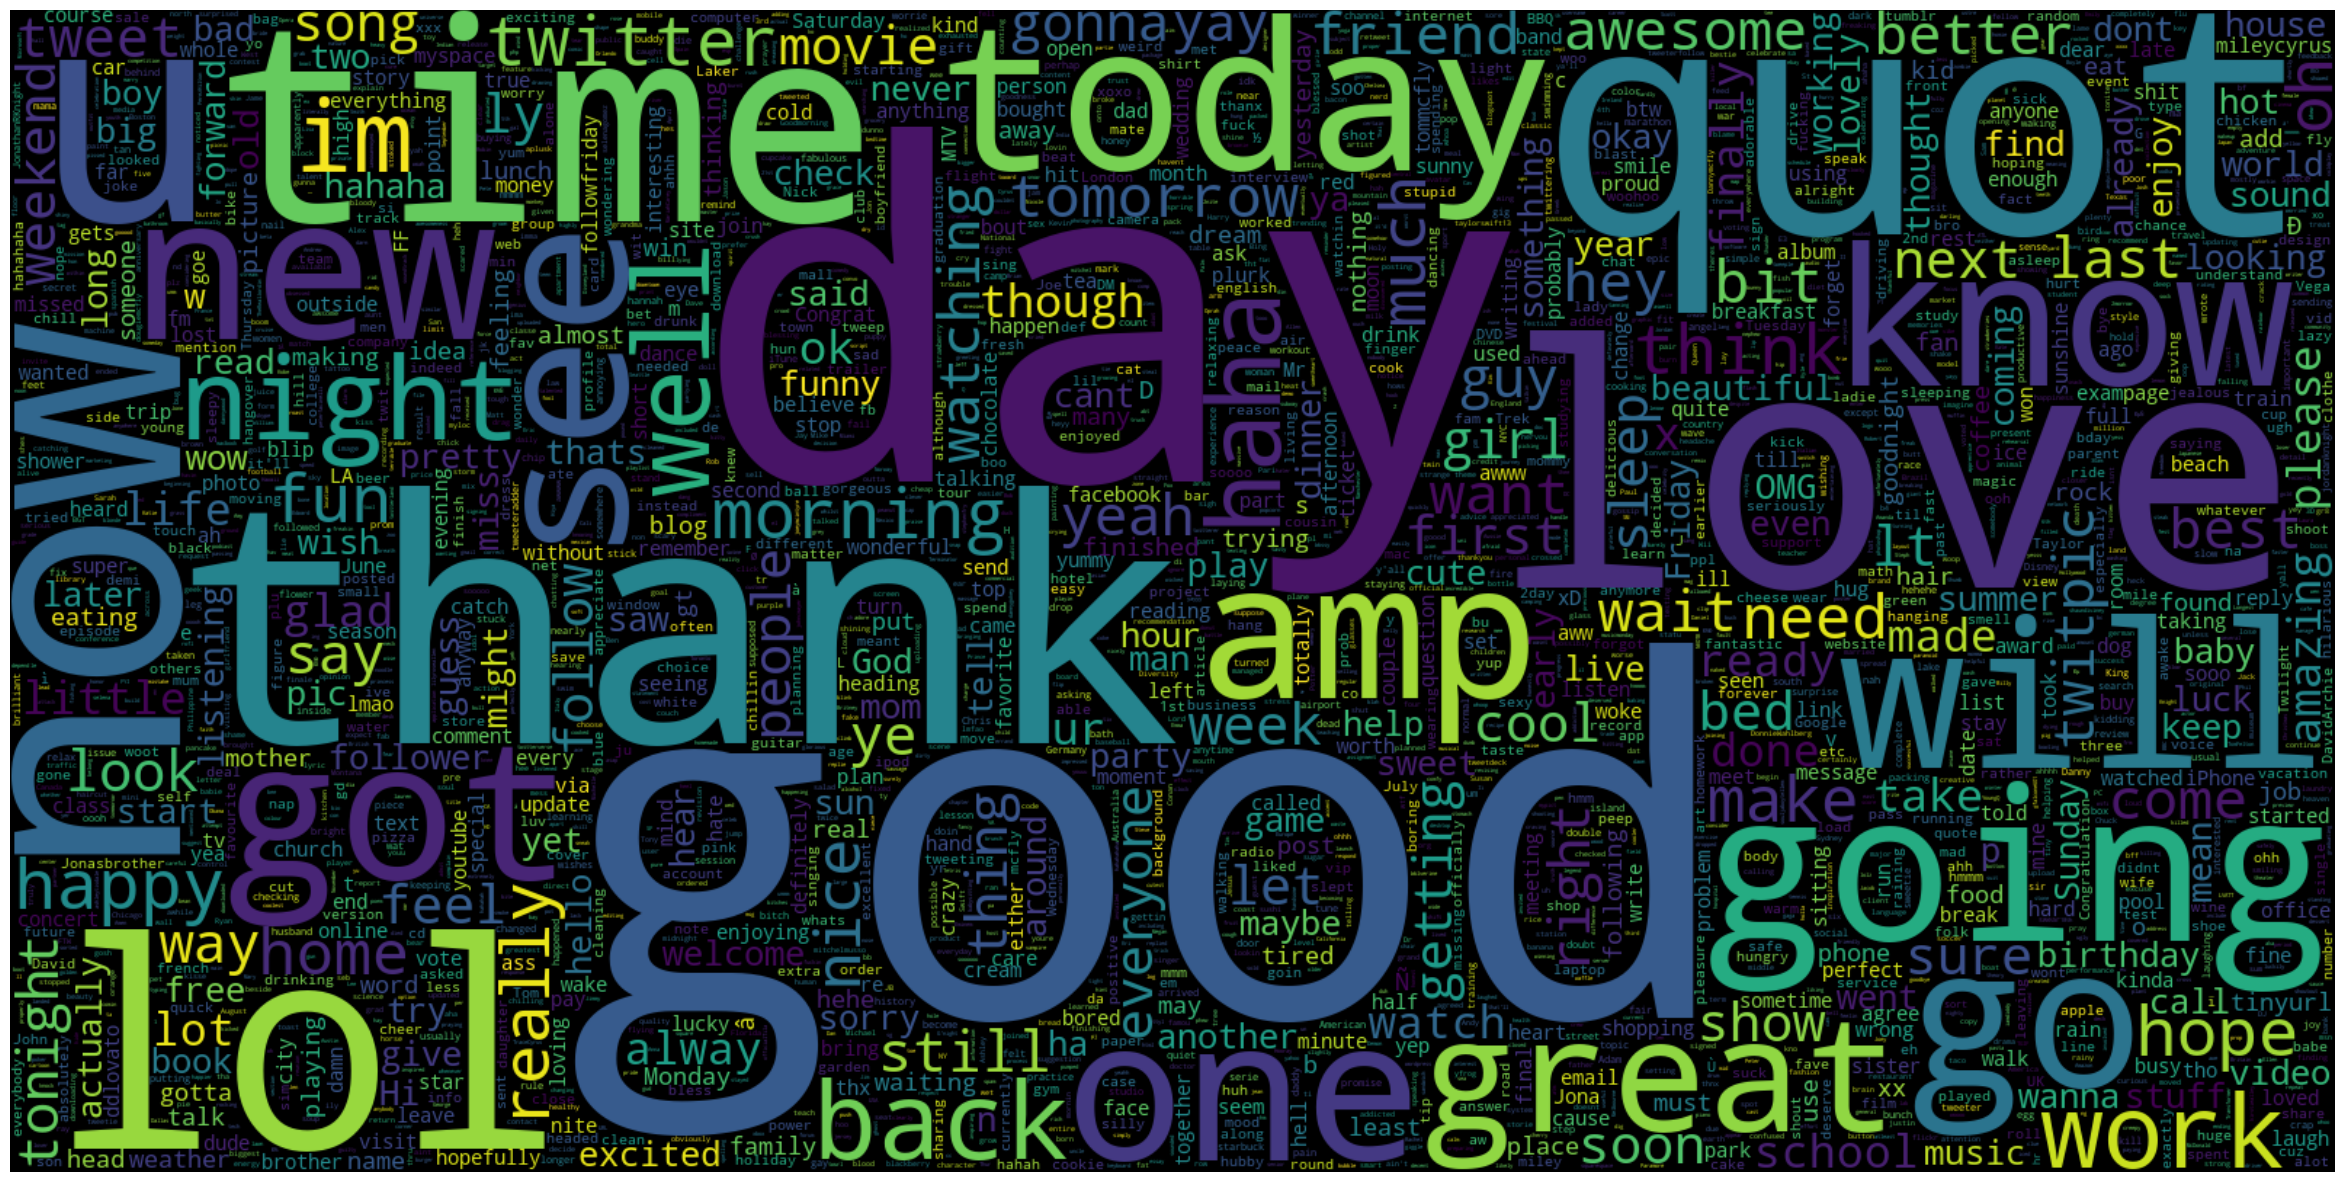

In [116]:
data_positive_df = data_df['text'][800000:]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 3000, width = 1600, height = 800, collocations = False).generate(" ".join(data_positive_df))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### **4. Model Preparation and Utilities**

#### 4.1 Data cross-validation

In [117]:
x = merged_df['text'].apply(lambda words: ' '.join(words))
y = merged_df['target']

x_as_text = merged_df_2['text']
y_as_text = merged_df_2['target']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state = 36104664)
X_train2, X_test2, y_train2, y_test2 = train_test_split(x_as_text, y_as_text, test_size=0.1, random_state = 36104664)

#### 4.2 TF-IDF Vectorizing

In [119]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features = 800000)
vectorizer.fit(X_train)
print("Vocabulary size:", len(vectorizer.vocabulary_))
print("Feature names:", vectorizer.get_feature_names_out())
print("IDF values:", vectorizer.idf_)

Vocabulary size: 800000
Feature names: ['aa' 'aagarw' 'aaspi' ... 'ø¹ù ø¹ù' 'ùø' 'ùøª']
IDF values: [12.87756997 13.38839559 13.38839559 ... 12.87756997 12.87756997
 13.38839559]


In [120]:
X_train_as_text = X_train2
X_test_as_text = X_test2

In [121]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

#### 4.3 Model Evaluation

In [122]:
def print_classification_report(y_pred, title):
    report = classification_report(y_test, y_pred)
    print("Classification Report: " + title)
    print(report)

In [123]:
def plot_confusion_matrix(y_pred, title):
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1} {v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues', fmt = '', xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size': 14}, labelpad = 10)
    plt.ylabel("Actual values", fontdict = {'size': 14}, labelpad = 10)
    plt.title("Confusion Matrix: " + title, fontdict = {'size': 18}, pad = 20)
    plt.show()

In [124]:
def plot_roc_curve(y_pred, title):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: ' + title)
    plt.legend(loc="lower right")
    plt.show()

In [125]:
def evaluate_model(model, title, yPred = None):
    y_pred = yPred
    if yPred is None:
         y_pred = model.predict(X_test)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
    print_classification_report(y_pred, title)
    plot_confusion_matrix(y_pred, title)
    plot_roc_curve(y_pred, title)

#### **5. Model Construction**

#### 5.1 Bernoulli Naive-Bayes Classifier

Accuracy Score: 0.7763
Classification Report: Bernoulli Naive-Bayes Classifier
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     39834
           1       0.76      0.80      0.78     40166

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



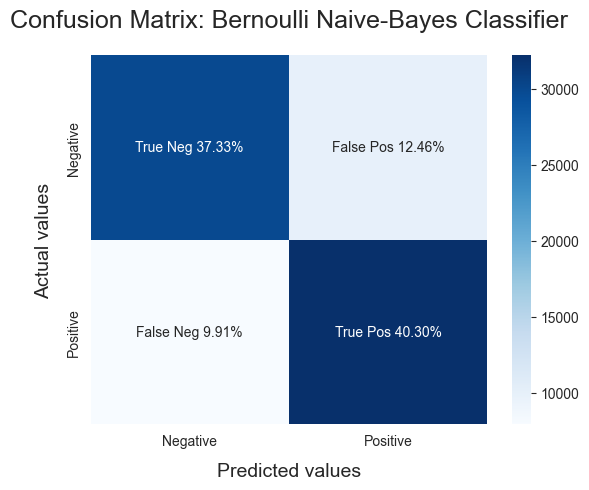

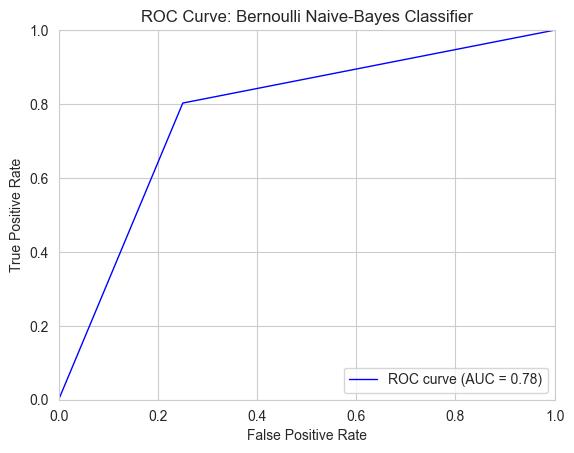

In [127]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
evaluate_model(BNBmodel, "Bernoulli Naive-Bayes Classifier")

#### 5.2 Logistic Regression

Accuracy Score: 0.7936625
Classification Report: Logistic Regression
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     39834
           1       0.79      0.80      0.80     40166

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



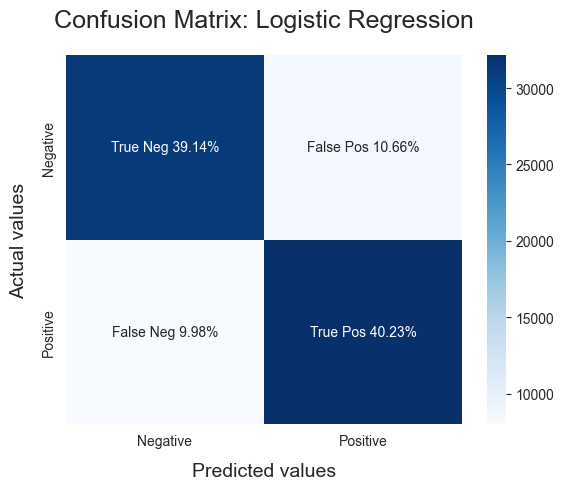

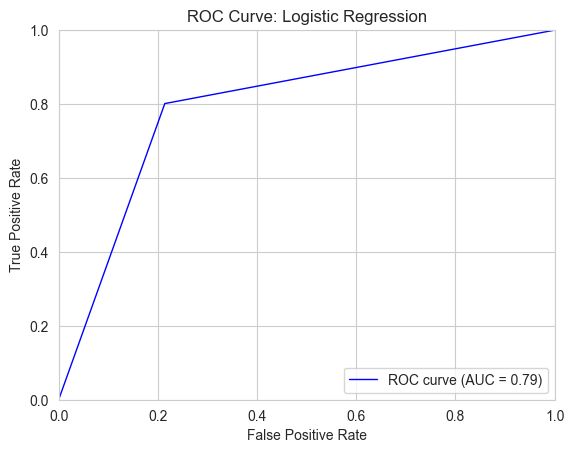

In [128]:
LRmodel = LogisticRegression(C = 2, max_iter = 10000, n_jobs = -1)
LRmodel.fit(X_train, y_train)
evaluate_model(LRmodel, "Logistic Regression")